# Assignment B.5 - Modern face recognition with deep learning

Have you noticed that Facebook has developed an uncanny ability to recognize your friends in your photographs? In the old days, Facebook used to make you to tag your friends in photos by clicking on them and typing in their name. Now as soon as you upload a photo, Facebook tags everyone for you like magic. This technology is called face recognition. Facebook’s algorithms are able to recognize your friends’ faces after they have been tagged only a few times. It’s pretty amazing: these algorithms can recognize faces with 98% accuracy, which is pretty much as good as humans can do!

As a human, your brain is wired to recognize faces automatically and instantly. Computers are not capable of doing this, so you have to teach them how to tackle each step in this process. Specifically, a face recognition system goes through four steps: find faces in the image, analyze their facial features, compare against known faces, and make a prediction of the corresponding persons. Here's described the full pipeline.

<img src="https://perso.esiee.fr/~najmanl/FaceRecognition/figures/summary.gif" style="height:200px;">

### Table of contents

In this assignment, you will tackle several problems related to face recognition:
1. **Face detection**. Look at a picture and find all the faces in it. -5
- **Pose estimation**. Understand where the face is turned and correct its pose. 5
- **Face encoding**. Pick up unique features from a face that can be used to distinguish it from others. 5
- **Face recognition**. Compare the unique features of a face to those of all the people in a database. 5
- **Personal dataset**. Build a custom face recognition dataset. 2

By the end of this notebook, you will have your own face recognition system.

### Required packages

Here are the packages you will need during the assignment.
- [Numpy](http://www.numpy.org)
- [Keras](https://keras.io)
- [OpenCV](https://opencv.org)
- [Dlib](http://dlib.net).

**Note**: In Anaconda Navigator, the package `dlib` can be installed from the **conda-forge** channel. In Google Colab, everything is readily available

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import cv2
import dlib
import os
import keras
import sklearn

2024-07-24 16:09:37.310229: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Face detection

The first step in your pipeline is face detection. Obviously you need to locate the faces in a photograph before you can try to tell them apart. If you’ve used any camera in the last 10 years, you’ve probably seen face detection in action. Face detection is a great feature for cameras. When the camera can automatically pick out faces, it can make sure that all the faces are in focus before it takes the picture. But you’ll use it for a different purpose:  finding the areas of the image you want to pass on to the next step in your pipeline.

<img src="https://perso.esiee.fr/~najmanl/FaceRecognition/figures/detection.jpg" style="height:200px;">

### Assignment

Here's what you are required to do for this part of the assignment.

- You are provided with a small dataset of pictures, where each picture contains exactly one face. Extract the faces and their labels (i.e., the person's names). Store them to a new file with the function `dump` in the package `pickle`.


-  Normalize the cropped faces (i.e., divide the pixel values by 255), and split them in train set (70%) and test set (30%) with the function `train_test_split` in the package `sklearn`.


- Train a small convnet and check its performance on the test set. Remember: don't use the test images for training.


- Try to improve the performance of the baseline convnet by using all the tricks you have learned in the course.

#### Provided functions

Here you will find some useful functions to complete the assignment.

In [2]:
!wget https://perso.esiee.fr/~najmanl/FaceRecognition/models.zip
!unzip models.zip

zsh:1: command not found: wget
unzip:  cannot find or open models.zip, models.zip.zip or models.zip.ZIP.


In [3]:
hog_detector = dlib.get_frontal_face_detector()
cnn_detector = dlib.cnn_face_detection_model_v1('models/mmod_human_face_detector.dat')

def face_locations(image, model="hog"):

    if model == "hog":
        detector = hog_detector
        cst = 0
    elif model == "cnn":
        detector = cnn_detector
        cst = 10

    matches = detector(image,1)
    rects   = []

    for r in matches:
        if model == "cnn":
            r = r.rect
        x = max(r.left(), 0)
        y = max(r.top(), 0)
        w = min(r.right(), image.shape[1]) - x + cst
        h = min(r.bottom(), image.shape[0]) - y + cst
        rects.append((x,y,w,h))

    return rects

In [4]:
def extract_faces(image, model="hog"):

    gray  = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    rects = face_locations(gray, model)
    faces = []

    for (x,y,w,h) in rects:
        cropped = image[y:y+h, x:x+w, :]
        cropped = cv2.resize(cropped, (128,128))
        faces.append(cropped)

    return faces

In [5]:
def show_grid(faces, figsize=(12,3)):

    n = len(faces)
    cols = 7
    rows = int(np.ceil(n/cols))

    fig, ax = plt.subplots(rows,cols, figsize=figsize)

    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            if i == n:
                 break
            ax[r,c].imshow(faces[i])
            ax[r,c].axis('off')
            #ax[r,c].set_title('size: ' + str(faces[i].shape[:2]))

In [6]:
def list_images(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"), contains=None):

    imagePaths = []

    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                imagePaths.append(imagePath)

    return imagePaths

#### Hints

The provided function `extract_faces()` applies face detection to a single input image, and returns a list of 128x128 blocks containing the detected faces.

In [7]:
!wget https://perso.esiee.fr/~najmanl/FaceRecognition/figures.zip
!unzip figures.zip

zsh:1: command not found: wget
unzip:  cannot find or open figures.zip, figures.zip.zip or figures.zip.ZIP.


In [8]:
image = cv2.imread("figures/faces.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

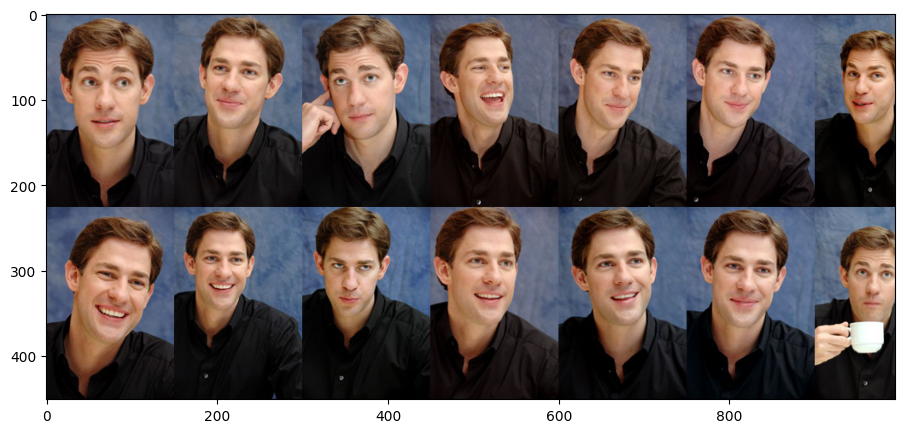

In [9]:
plt.figure(figsize=(15,5))
plt.imshow(image)

In [10]:
faces = extract_faces(image, "cnn")  # Replace 'cnn' with 'hog' for faster but less accurate results

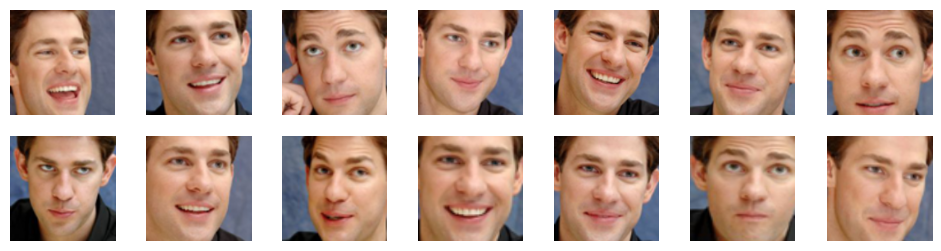

In [11]:
show_grid(faces)

Moreover, the function `list_images()` locates all the jpeg/png/tiff files in a given folder (including its subfolders).

In [12]:
!wget https://perso.esiee.fr/~najmanl/FaceRecognition/data.zip
!unzip data.zip

zsh:1: command not found: wget
unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


In [13]:
imagePaths = list_images("data")
imagePaths

['data/owen_grady/00000010.jpg',
 'data/owen_grady/00000004.jpg',
 'data/owen_grady/00000005.jpg',
 'data/owen_grady/00000007.jpg',
 'data/owen_grady/00000013.jpg',
 'data/owen_grady/00000012.jpg',
 'data/owen_grady/00000006.jpg',
 'data/owen_grady/00000002.jpg',
 'data/owen_grady/00000016.jpg',
 'data/owen_grady/00000017.jpg',
 'data/owen_grady/00000003.jpg',
 'data/owen_grady/00000015.jpg',
 'data/owen_grady/00000001.jpg',
 'data/owen_grady/00000029.jpg',
 'data/owen_grady/00000000.jpg',
 'data/owen_grady/00000014.jpg',
 'data/owen_grady/00000070.jpg',
 'data/owen_grady/00000059.jpg',
 'data/owen_grady/00000027.jpeg',
 'data/owen_grady/00000047.jpg',
 'data/owen_grady/00000086.jpg',
 'data/owen_grady/00000068.jpg',
 'data/owen_grady/00000083.jpg',
 'data/owen_grady/00000041.jpg',
 'data/owen_grady/00000080.jpg',
 'data/owen_grady/00000019.jpg',
 'data/owen_grady/00000024.jpg',
 'data/owen_grady/00000030.jpg',
 'data/owen_grady/00000018.jpg',
 'data/owen_grady/00000026.jpg',
 'data/ow

In [14]:

"""You are provided with a small dataset of pictures, where each picture contains exactly one face. Extract the faces and their labels (i.e., the person's names). Store them to a new file with the function dump in the package pickle.
Normalize the cropped faces (i.e., divide the pixel values by 255), and split them in train set (70%) and test set (30%) with the function train_test_split in the package sklearn.
Train a small convnet and check its performance on the test set. Remember: don't use the test images for training.
Try to improve the performance of the baseline convnet by using all the tricks you have learned in the course.
"""
import numpy as np
import cv2
import dlib
import os
import pickle
from sklearn.model_selection import train_test_split
from keras import layers, models
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
#from tensorflow.keras.preprocessing import image

In [15]:
"""
# Define base path and load images
basePath = "data"
imagePaths = list_images(basePath)

# Create dataset by extracting faces and their labels
dataset = []
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    faces = extract_faces(image, model="cnn")  # Use CNN for better accuracy
    
    if not faces: #condition pour éviter les images sans visage détecter
      print("Aucun visage détecté dans l'image :",imagePath)
    else:
      label = os.path.basename(os.path.dirname(imagePath))
      for face in faces:
          dataset.append((face, label))

# Store the dataset in a file using pickle
with open("faces_dataset.pkl", "wb") as f:
    pickle.dump(dataset, f)
"""

'\n# Define base path and load images\nbasePath = "data"\nimagePaths = list_images(basePath)\n\n# Create dataset by extracting faces and their labels\ndataset = []\nfor imagePath in imagePaths:\n    image = cv2.imread(imagePath)\n    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\n    faces = extract_faces(image, model="cnn")  # Use CNN for better accuracy\n    \n    if not faces: #condition pour éviter les images sans visage détecter\n      print("Aucun visage détecté dans l\'image :",imagePath)\n    else:\n      label = os.path.basename(os.path.dirname(imagePath))\n      for face in faces:\n          dataset.append((face, label))\n\n# Store the dataset in a file using pickle\nwith open("faces_dataset.pkl", "wb") as f:\n    pickle.dump(dataset, f)\n'

In [16]:
#open and load the dataset
with open("faces_dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

# Normalize faces and split dataset into train and test sets
faces = np.array([data[0] for data in dataset])
labels = np.array([data[1] for data in dataset])

normalized_faces = faces / 255.0

label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)

train_faces, test_faces, train_labels, test_labels = train_test_split(normalized_faces, integer_labels, test_size=0.3, random_state=42)


In [17]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,414 (12.61 MB)

 Trainable params: 3,305,414 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 411ms/step - accuracy: 0.0955 - loss: 1.9457 - val_accuracy: 0.4333 - val_loss: 1.7656
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 0.2680 - loss: 1.7478 - val_accuracy: 0.2333 - val_loss: 1.7066
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 378ms/step - accuracy: 0.3008 - loss: 1.6770 - val_accuracy: 0.3000 - val_loss: 1.5925
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/step - accuracy: 0.4325 - loss: 1.4756 - val_accuracy: 0.4333 - val_loss: 1.4681
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 404ms/step - accuracy: 0.4594 - loss: 1.2881 - val_accuracy: 0.4000 - val_loss: 1.3655
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step - accuracy: 0.5305 - loss: 1.1287 - val_accuracy: 0.4000 - val_loss: 1.3654
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step - accuracy: 0.5877 - loss: 1.0783 - val_accuracy: 0.4667 - val_loss: 1.3177
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 347ms/step - accuracy: 0.6287 - loss: 0.8888 - val_accuracy: 0.5000 - val_loss:

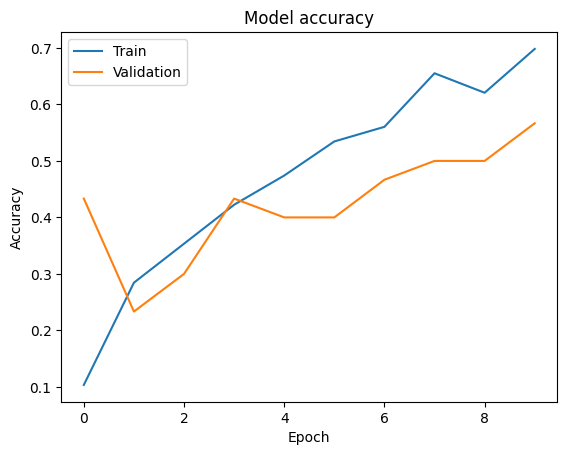

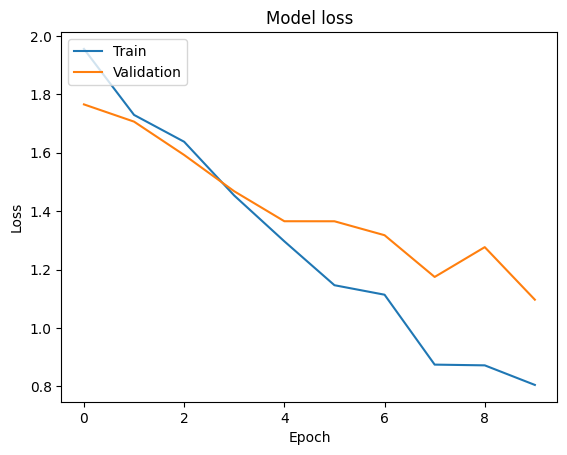

In [18]:
# Define and train a simple ConvNet
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(len(np.unique(train_labels)), activation='softmax'))  # Output layer with softmax for multi-class classification

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_faces, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_faces, test_labels)
print("Test accuracy:", test_acc * 100)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 2. Pose estimation

You have isolated the faces in our image. But now you have to deal with the problem that faces turned different directions look totally different to a computer. To account for this, you will try to warp each picture so that the eyes and lips are always in the same place in the image. More concretely, you are going to use an algorithm called face landmark estimation. The basic idea is to locate 68 specific points (called landmarks) that exist on every face:  the top of the chin, the outside edge of each eye, the inner edge of each eyebrow, etc. Then, you’ll simply rotate, scale and shear the image so that the eyes and mouth are centered as best as possible. This will make face recognition more accurate.

<img src="https://perso.esiee.fr/~najmanl/FaceRecognition/figures/pose.png" style="height:200px;">

### Assignment

Here's what you are required to do for this part of the assignment.

- Further preprocess the face pictures by correcting their pose. You should now have a dataset of cropped, aligned, and normalized faces.


- Re-train your convnets on the modified dataset.


- Evaluate the performance on the test set, and compare it to the scores obtained with your previously trained convnets.

#### Provided functions

Here you will find some useful functions to complete the assignment.

In [19]:
pose68 = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
pose05 = dlib.shape_predictor('models/shape_predictor_5_face_landmarks.dat')

def face_landmarks(face, model="large"):

    if model == "large":
        predictor = pose68
    elif model == "small":
        predictor = pose05

    if not isinstance(face, list):
        rect = dlib.rectangle(0,0,face.shape[1],face.shape[0])
        return predictor(face, rect)
    else:
        rect = dlib.rectangle(0,0,face[0].shape[1],face[0].shape[0])
        return [predictor(f,rect) for f in face]

In [20]:
def shape_to_coords(shape):
    return np.float32([[p.x, p.y] for p in shape.parts()])

In [21]:
TEMPLATE = np.float32([
    (0.0792396913815, 0.339223741112), (0.0829219487236, 0.456955367943),
    (0.0967927109165, 0.575648016728), (0.122141515615, 0.691921601066),
    (0.168687863544, 0.800341263616), (0.239789390707, 0.895732504778),
    (0.325662452515, 0.977068762493), (0.422318282013, 1.04329000149),
    (0.531777802068, 1.06080371126), (0.641296298053, 1.03981924107),
    (0.738105872266, 0.972268833998), (0.824444363295, 0.889624082279),
    (0.894792677532, 0.792494155836), (0.939395486253, 0.681546643421),
    (0.96111933829, 0.562238253072), (0.970579841181, 0.441758925744),
    (0.971193274221, 0.322118743967), (0.163846223133, 0.249151738053),
    (0.21780354657, 0.204255863861), (0.291299351124, 0.192367318323),
    (0.367460241458, 0.203582210627), (0.4392945113, 0.233135599851),
    (0.586445962425, 0.228141644834), (0.660152671635, 0.195923841854),
    (0.737466449096, 0.182360984545), (0.813236546239, 0.192828009114),
    (0.8707571886, 0.235293377042), (0.51534533827, 0.31863546193),
    (0.516221448289, 0.396200446263), (0.517118861835, 0.473797687758),
    (0.51816430343, 0.553157797772), (0.433701156035, 0.604054457668),
    (0.475501237769, 0.62076344024), (0.520712933176, 0.634268222208),
    (0.565874114041, 0.618796581487), (0.607054002672, 0.60157671656),
    (0.252418718401, 0.331052263829), (0.298663015648, 0.302646354002),
    (0.355749724218, 0.303020650651), (0.403718978315, 0.33867711083),
    (0.352507175597, 0.349987615384), (0.296791759886, 0.350478978225),
    (0.631326076346, 0.334136672344), (0.679073381078, 0.29645404267),
    (0.73597236153, 0.294721285802), (0.782865376271, 0.321305281656),
    (0.740312274764, 0.341849376713), (0.68499850091, 0.343734332172),
    (0.353167761422, 0.746189164237), (0.414587777921, 0.719053835073),
    (0.477677654595, 0.706835892494), (0.522732900812, 0.717092275768),
    (0.569832064287, 0.705414478982), (0.635195811927, 0.71565572516),
    (0.69951672331, 0.739419187253), (0.639447159575, 0.805236879972),
    (0.576410514055, 0.835436670169), (0.525398405766, 0.841706377792),
    (0.47641545769, 0.837505914975), (0.41379548902, 0.810045601727),
    (0.380084785646, 0.749979603086), (0.477955996282, 0.74513234612),
    (0.523389793327, 0.748924302636), (0.571057789237, 0.74332894691),
    (0.672409137852, 0.744177032192), (0.572539621444, 0.776609286626),
    (0.5240106503, 0.783370783245), (0.477561227414, 0.778476346951)])

TPL_MIN, TPL_MAX = np.min(TEMPLATE, axis=0), np.max(TEMPLATE, axis=0)
MINMAX_TEMPLATE = (TEMPLATE - TPL_MIN) / (TPL_MAX - TPL_MIN)

INNER_EYES_AND_BOTTOM_LIP = np.array([39, 42, 57])
OUTER_EYES_AND_NOSE = np.array([36, 45, 33])

In [22]:
def align_faces(images, landmarks, idx=INNER_EYES_AND_BOTTOM_LIP):
    faces = []
    for (img, marks) in zip(images, landmarks):
        imgDim = img.shape[0]
        coords = shape_to_coords(marks)
        H = cv2.getAffineTransform(coords[idx], imgDim * MINMAX_TEMPLATE[idx])
        warped = cv2.warpAffine(img, H, (imgDim, imgDim))
        faces.append(warped)
    return faces

#### Hints

The provided function `face_landmarks()` computes the landmarks for a list of cropped faces.

In [23]:
image = cv2.imread("figures/faces.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
faces = extract_faces(image, "cnn")
landmarks = face_landmarks(faces)

In [24]:
new_faces = []
for (face,shape) in zip(faces, landmarks):
    canvas = face.copy()
    coords = shape_to_coords(shape)
    for p in coords:
        cv2.circle(canvas, (int(p[0]),int(p[1])), 1, (0, 0, 255), -1)
    new_faces.append(canvas)

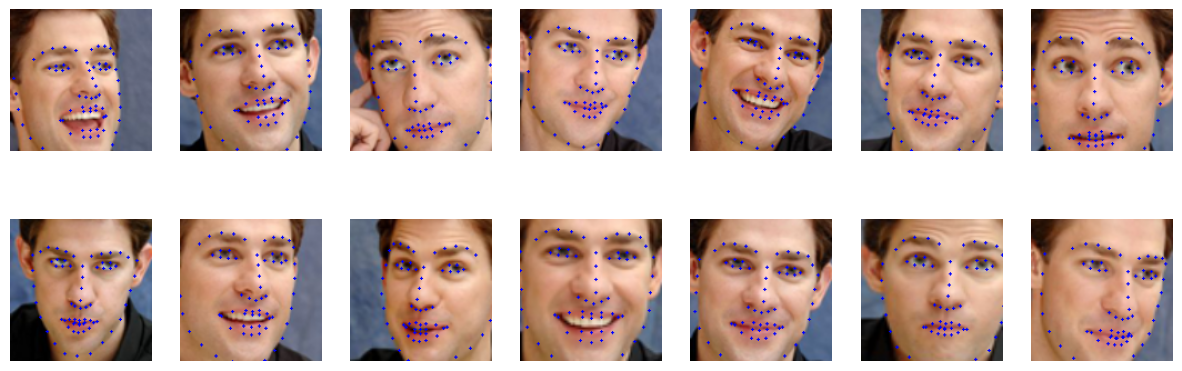

In [25]:
show_grid(new_faces, figsize=(15,5))

In [26]:
aligned = align_faces(faces, landmarks)

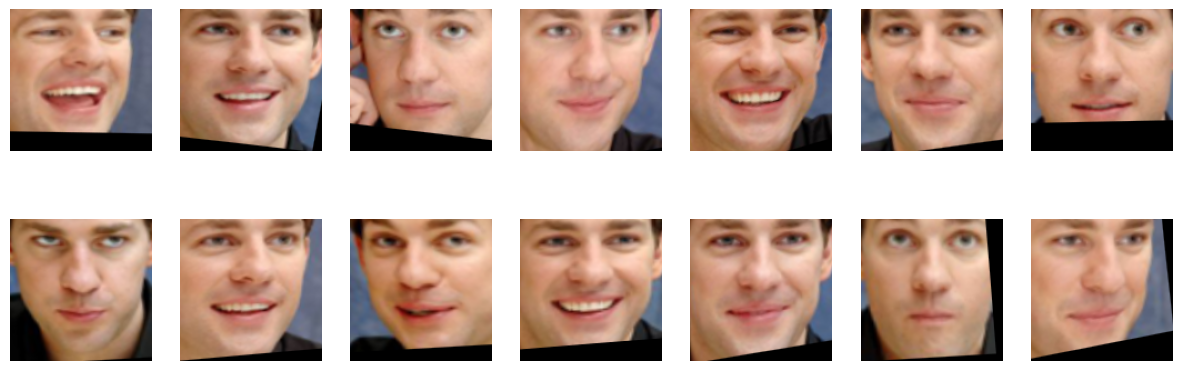

In [27]:
show_grid(aligned, figsize=(15,5))

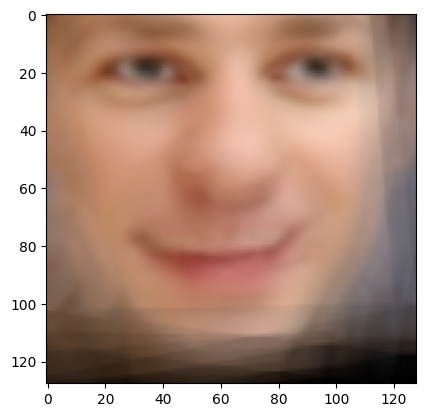

In [28]:
plt.imshow( np.stack(aligned, axis=3).astype(np.float32).mean(axis=3)/255 )

In [29]:
"""
basePath = "data"
imagePaths = list_images(basePath)

# Create dataset by extracting faces and their labels
dataset2 = []
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    faces = extract_faces(image, model="cnn")  # Use CNN for better accuracy
    
    if not faces: #condition pour éviter les images sans visage détecté
      print("Aucun visage détecté dans l'image :",imagePath)
    else:
      label = os.path.basename(os.path.dirname(imagePath))
      landmarks = face_landmarks(faces)
      aligned = align_faces(faces, landmarks)
      for face in aligned :
          dataset2.append((face, label))

# Store the dataset in a file using pickle
with open("aligned_faces_dataset.pkl", "wb") as f:
    pickle.dump(dataset2, f)
"""

'\nbasePath = "data"\nimagePaths = list_images(basePath)\n\n# Create dataset by extracting faces and their labels\ndataset2 = []\nfor imagePath in imagePaths:\n    image = cv2.imread(imagePath)\n    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\n    faces = extract_faces(image, model="cnn")  # Use CNN for better accuracy\n    \n    if not faces: #condition pour éviter les images sans visage détecté\n      print("Aucun visage détecté dans l\'image :",imagePath)\n    else:\n      label = os.path.basename(os.path.dirname(imagePath))\n      landmarks = face_landmarks(faces)\n      aligned = align_faces(faces, landmarks)\n      for face in aligned :\n          dataset2.append((face, label))\n\n# Store the dataset in a file using pickle\nwith open("aligned_faces_dataset.pkl", "wb") as f:\n    pickle.dump(dataset2, f)\n'

In [30]:
with open("aligned_faces_dataset.pkl", "rb") as f:
    dataset2 = pickle.load(f)
# Normalize faces and split dataset into train and test sets
faces = np.array([data[0] for data in dataset2])
labels = np.array([data[1] for data in dataset2])

new_faces = faces / 255.0

label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
train_faces, test_faces, train_labels, test_labels = train_test_split(new_faces, integer_labels, test_size=0.3, random_state=42)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,414 (12.61 MB)

 Trainable params: 3,305,414 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - accuracy: 0.2372 - loss: 2.1887 - val_accuracy: 0.2667 - val_loss: 1.8091
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 348ms/step - accuracy: 0.1966 - loss: 1.8076 - val_accuracy: 0.2333 - val_loss: 1.7439
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step - accuracy: 0.2548 - loss: 1.7290 - val_accuracy: 0.2333 - val_loss: 1.7302
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 375ms/step - accuracy: 0.2593 - loss: 1.6890 - val_accuracy: 0.3000 - val_loss: 1.7081
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 435ms/step - accuracy: 0.3646 - loss: 1.6238 - val_accuracy: 0.2667 - val_loss: 1.6458
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 482ms/step - accuracy: 0.4151 - loss: 1.4984 - val_accuracy: 0.4667 - val_loss: 1.5554
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - accuracy: 0.4567 - loss: 1.4167 - val_accuracy: 0.5667 - val_loss: 1.4005
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - accuracy: 0.6133 - loss: 1.1641 - val_accuracy: 0.5667 - val_loss:

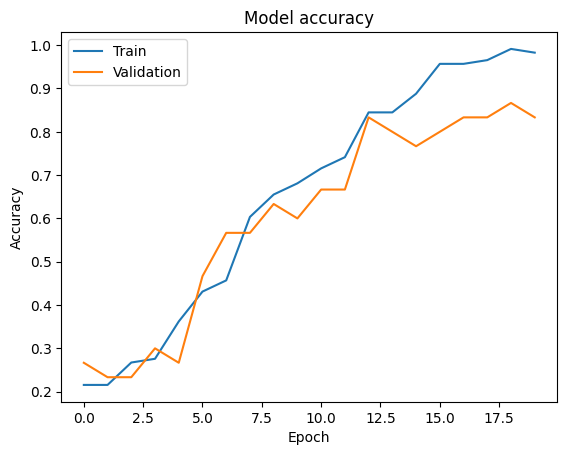

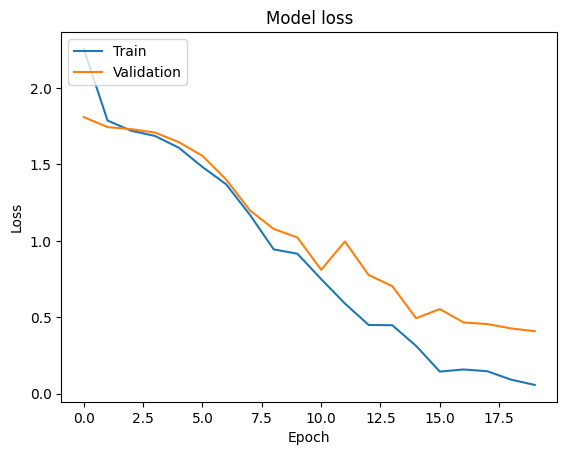

In [31]:
# Define and train a simple ConvNet
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(rate=0.2))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(len(np.unique(train_labels)), activation='softmax'))  # Output layer with softmax for multi-class classification

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_faces, train_labels, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_faces, test_labels)
print("Test accuracy:", test_acc * 100)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 3. Face encoding

The simplest approach to face recognition is to directly classify an unknown face with a convnet trained on your database of tagged people. Seems like a pretty good idea, right? There’s actually a huge problem with that approach. A site like Facebook with billions of users and a trillion photos can’t possibly train such a big convnet. That would take way too long. What you need is a way to extract a few basic measurements from each face, which you can then use to quickly compare the unknown face with your database. For example, you might measure the size of each ear, the spacing between the eyes, the length of the nose, etc. However, it turns out that the measurements that seem obvious to us humans (like eye color) don’t really make sense to a computer looking at individual pixels in an image. Researchers have discovered that the most accurate approach is to let the computer figure out the measurements to collect itself. Deep learning does a better job than humans at figuring out which parts of a face are important to measure.

The solution is to train a convnet. But instead of training the network to classify pictures, it is trained to generate 128 measurements for each face. The training process works by looking at 3 face images at a time: the picture of a known person, another picture of the same known person, and a picture of a totally different person. Then, the algorithm looks at the measurements currently generated for each of those three images. It tweaks the neural network slightly to make sure that the measurements generated for the same person are slightly closer, and the measurements for different persons are slightly further apart. After repeating this step millions of times for millions of images of thousands of different people, the convnet learns to generate 128 measurements for each person.

<img src="https://perso.esiee.fr/~najmanl/FaceRecognition/figures/triplet.png" style="height:400px;">

This process of training a convnet to output face encodings requires a lot of data and computer power. Even with an expensive GPU, it takes about 24 hours of continuous training to get good accuracy. But once the network has been trained, it can generate measurements for any face, even ones it has never seen before! So this step only needs to be done once. Fortunately, the people at [OpenFace](https://cmusatyalab.github.io/openface/) already did this and they published several trained networks which you can directly use. So all you need to do is run your face images through their pre-trained network to get the 128 measurements for each face.

<img src="https://perso.esiee.fr/~najmanl/FaceRecognition/figures/encoding.png" style="height:300px;">

### Assignment

Here's what you are required to do for this part of the assignment.

- Preprocess the cropped faces by encoding them. You should now have a dataset of cropped and encoded faces.


- Train a neural network on the modified dataset. Since the encoded faces are just 128-length vectors, **you don't need a convnet**. Use a regular neural network with a series of fully-connected layers.


- Evaluate the performance on the test set, and compare it to the scores obtained with your previously trained convnets.

#### Provided functions

In [32]:
cnn_encoder = dlib.face_recognition_model_v1('models/dlib_face_recognition_resnet_model_v1.dat')

def face_encoder(faces):

    landmarks = face_landmarks(faces)

    if not isinstance(faces, list):
        return np.array(cnn_encoder.compute_face_descriptor(faces,landmarks))
    else:
        return np.array([cnn_encoder.compute_face_descriptor(f,l) for f,l in zip(faces,landmarks)])

#### Hints

The provided function `face_encoder()` computes the encodings for a list of cropped faces. Alignment and normalization are handled internally.

In [33]:
image = cv2.imread("figures/faces.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
faces = extract_faces(image, "cnn")

In [34]:
encoded_faces = face_encoder(faces)

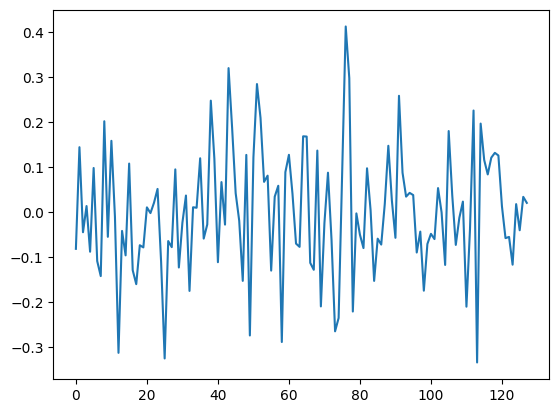

In [35]:
plt.plot(encoded_faces[0])

In [36]:
"""
basePath = "data"
imagePaths = list_images(basePath)

# Create dataset by extracting faces and their labels
dataset3 = []
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    faces = extract_faces(image, model="cnn")  # Use CNN for better accuracy
    
    if not faces: #condition pour éviter les images sans visage détecter
      print("Aucun visage détecté dans l'image :",imagePath)
    else:
      label = os.path.basename(os.path.dirname(imagePath))
      landmarks = face_landmarks(faces)
      aligned = align_faces(faces, landmarks)
      encoded_faces = face_encoder(aligned)
      for encoded_face in encoded_faces :
          dataset3.append((encoded_face, label))

# Store the dataset in a file using pickle
with open("encoded_faces_dataset.pkl", "wb") as f:
    pickle.dump(dataset3, f)"
"""

'\nbasePath = "data"\nimagePaths = list_images(basePath)\n\n# Create dataset by extracting faces and their labels\ndataset3 = []\nfor imagePath in imagePaths:\n    image = cv2.imread(imagePath)\n    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\n    faces = extract_faces(image, model="cnn")  # Use CNN for better accuracy\n    \n    if not faces: #condition pour éviter les images sans visage détecter\n      print("Aucun visage détecté dans l\'image :",imagePath)\n    else:\n      label = os.path.basename(os.path.dirname(imagePath))\n      landmarks = face_landmarks(faces)\n      aligned = align_faces(faces, landmarks)\n      encoded_faces = face_encoder(aligned)\n      for encoded_face in encoded_faces :\n          dataset3.append((encoded_face, label))\n\n# Store the dataset in a file using pickle\nwith open("encoded_faces_dataset.pkl", "wb") as f:\n    pickle.dump(dataset3, f)"\n'

In [37]:
from keras.utils import to_categorical
#open and load the dataset
with open("encoded_faces_dataset.pkl", "rb") as f:
    dataset3 = pickle.load(f)
    
# Normalize faces and split dataset into train and test sets
vectors = np.array([data[0] for data in dataset3])
labels  = np.array([data[1] for data in dataset3])

label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
train_faces, test_faces, train_labels, test_labels = train_test_split(vectors, integer_labels, test_size=0.3, random_state=42)

num_classes = len(label_encoder.classes_)

# Convertir les étiquettes en one-hot
train_labels_one_hot = to_categorical(train_labels, num_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes)

Epoch 1/40


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.1930 - loss: 1.7818 - val_accuracy: 0.2000 - val_loss: 1.6457
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2874 - loss: 1.6636 - val_accuracy: 0.2000 - val_loss: 1.5262
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2674 - loss: 1.5987 - val_accuracy: 0.5333 - val_loss: 1.4104
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4959 - loss: 1.4641 - val_accuracy: 0.8000 - val_loss: 1.2941
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6303 - loss: 1.3761 - val_accuracy: 0.9333 - val_loss: 1.2406
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7544 - loss: 1.2619 - val_accuracy: 0.9333 - val_loss: 1.1028
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7972 - loss: 1.1103 - val_accuracy: 0.9333 - val_loss: 0.9326
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8428 - loss: 0.9727 - val_accuracy: 0.8667 - val_loss: 0.8154
Epoch 9/40
5/5 ━━━

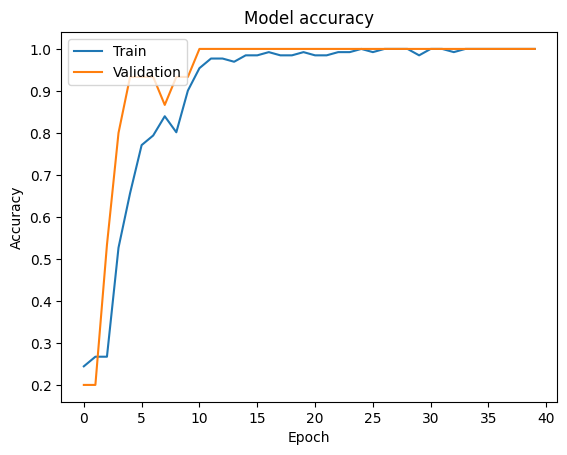

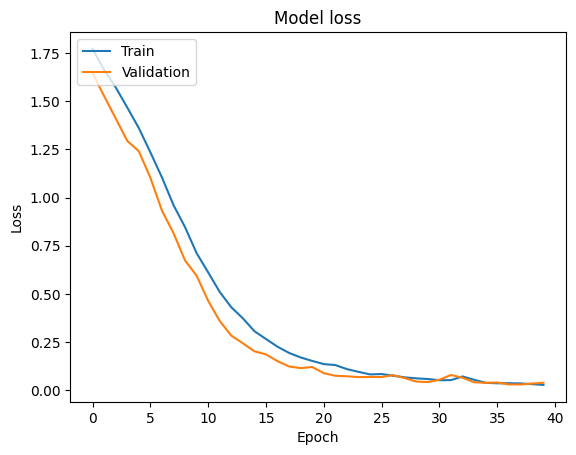

In [38]:


# Définir et compiler le modèle
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(128,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle avec les étiquettes en one-hot
history = model.fit(train_faces, train_labels_one_hot, epochs=40, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_faces, test_labels_one_hot)
print("Test accuracy:", test_acc * 100)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 4. Face recognition

This last step is actually the easiest one in the whole process. All you have to do is find the person in your database of known people who has the closest measurements to some test image. You can do that by using any machine learning classification algorithm, such as neaural network (as you did in the previous section), logistic regression, SVM, nearest neighbours, etc. All you need to do is training a classifier that can take in the measurements from a new test image, and tells which known person is the closest match. Running this classifier must only take milliseconds, so that you can apply it to video sequences.

<img src="https://perso.esiee.fr/~najmanl/FaceRecognition/figures/test.gif" style="height:300px;">

### Assignment

Here's what you are required to do for this part of the assignment.

-  Train several classifiers (logistic regression, SVM, kNN, neural network) on the dataset of encoded faces (you can use the package `scikit-learn`).

- Evaluate their performance on the test set, in terms of accuracy and speed.

- Finally, run your best classifier on the test images and video available in the `test` folder.

#### Provided functions

In [39]:
def process_frame(image, mode="fast"):

    # face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if mode == "fast":
        matches = hog_detector(gray,1)
    else:
        matches = cnn_detector(gray,1)
        matches = [m.rect for m in matches]

    for rect in matches:

        # face landmarks
        landmarks = pose68(gray, rect)

        # face encoding
        encoding = cnn_encoder.compute_face_descriptor(image, landmarks)

        # face classification
        label = "label"

        # draw box
        cv2.rectangle(image, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 2)
        y = rect.top() - 15 if rect.top() - 15 > 15 else rect.bottom() + 25
        cv2.putText(image, label, (rect.left(), y), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)

    return image

**Note:** cv2.VideoCapture does not work in Google Colab. You can use https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb#scrollTo=2viqYx97hPMi to capture video 'on the fly' with Google Colab. The following function has to be modified accordingly

In [40]:
def process_movie(video_name, mode="fast"):

    video  = cv2.VideoCapture(video_name)

    try:

        while True:

            # Grab a single frame of video
            ret, frame = video.read()

            # Resize frame of video for faster processing
            frame = cv2.resize(frame, (0, 0), fx=0.5, fy=0.5)

            # Quit when the input video file ends or key "Q" is pressed
            key = cv2.waitKey(1) & 0xFF
            if not ret or key == ord("q"):
                break

            # Process frame
            image = process_frame(frame, mode)

            # Display the resulting image
            cv2.imshow('Video', image)

    finally:
        video.release()
        cv2.destroyAllWindows()
        print("Video released")

#### Hints

The provided function `process_frame()` detects and encodes all the faces in the input image.

In [41]:
!wget https://perso.esiee.fr/~najmanl/FaceRecognition/test.zip
!unzip test.zip

zsh:1: command not found: wget
unzip:  cannot find or open test.zip, test.zip.zip or test.zip.ZIP.


In [42]:
image = cv2.imread("test/example_03.png")

In [43]:
processed = process_frame(image.copy())
processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)

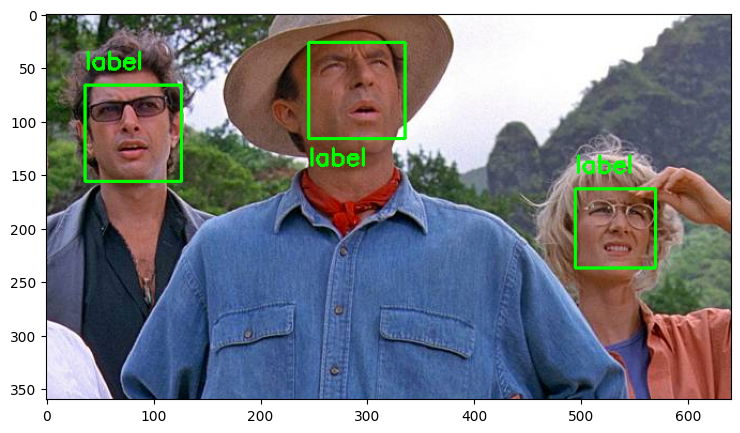

In [44]:
plt.figure(figsize=(15,5))
plt.imshow(processed)

The provided function `process_frame()` detects and encodes the faces in the input video.

In [45]:
#process_movie("test/lunch_scene.mp4")

The special input `0` can be used to access the webcam.

In [46]:
#process_movie(0)

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import time

# Train classifiers
log_reg = LogisticRegression()
svm_clf = SVC()
knn_clf = KNeighborsClassifier()
mlp_clf = MLPClassifier()

classifiers = [log_reg, svm_clf, knn_clf, mlp_clf]
classifier_names = ['Logistic Regression', 'SVM', 'kNN', 'Neural Network']

for clf, name in zip(classifiers, classifier_names):
    start_time = time.time()
    clf.fit(train_faces, train_labels)
    train_time = time.time() - start_time
    pred = clf.predict(test_faces)
    accuracy = accuracy_score(test_labels, pred)
    print(f"{name}: Accuracy = {accuracy}, Training Time = {train_time}")

Logistic Regression: Accuracy = 0.9682539682539683, Training Time = 0.01812291145324707
SVM: Accuracy = 0.9523809523809523, Training Time = 0.0029649734497070312
kNN: Accuracy = 0.9682539682539683, Training Time = 0.00045108795166015625
Neural Network: Accuracy = 0.9682539682539683, Training Time = 0.20134687423706055


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [48]:
from keras.utils import to_categorical
#open and load the dataset
with open("encoded_faces_dataset.pkl", "rb") as f:
    dataset3 = pickle.load(f)
    
# Normalize faces and split dataset into train and test sets
vectors = np.array([data[0] for data in dataset3])
labels  = np.array([data[1] for data in dataset3])

label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
train_faces, test_faces, train_labels, test_labels = train_test_split(vectors, integer_labels, test_size=0.3, random_state=42)

num_classes = len(label_encoder.classes_)

# Convertir les étiquettes en one-hot
train_labels_one_hot = to_categorical(train_labels, num_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes)

# Run the best classifier on test images
model = knn_clf  # Choisissez le meilleur classificateur en fonction des performances
# Entraîner le modèle avec les étiquettes en one-hot
model.fit(train_faces, train_labels_one_hot)
# Evaluate the model on the test set
pred = model.predict(test_faces)
accuracy = accuracy_score(test_labels_one_hot, pred)
print(f"{name}: Accuracy = {accuracy}, Training Time = {train_time}")


Neural Network: Accuracy = 0.9682539682539683, Training Time = 0.20134687423706055


In [49]:
def identify_frame(image, label_encoder, mode="fast"):
    
    # face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if mode == "fast":
        matches = hog_detector(gray,1)
    else:
        matches = cnn_detector(gray,1)
        matches = [m.rect for m in matches]

    for rect in matches:

        # face landmarks
        landmarks = pose68(gray, rect)

        # face encoding
        encoding = cnn_encoder.compute_face_descriptor(image, landmarks)

        # face classification
        pred = model.predict([encoding])
        pred = np.argmax(pred, axis=1)
        
        label = label_encoder.inverse_transform(pred)
        # draw box
        cv2.rectangle(image, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 255, 0), 2)
        y = rect.top() - 15 if rect.top() - 15 > 15 else rect.bottom() + 25
        cv2.putText(image, label[0], (rect.left(), y), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)

    return image

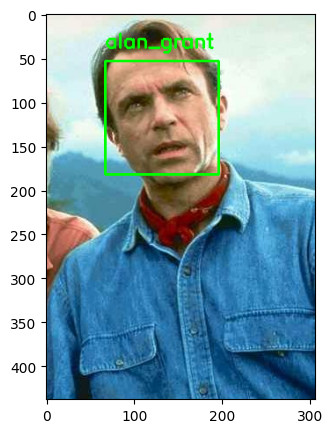

In [50]:
image = cv2.imread("data/alan_grant/00000041.jpg")
processed = identify_frame(image.copy(),label_encoder)
processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,5))
plt.imshow(processed)

In [51]:
def identify_movie(video_name, label_encoder, mode="fast"):

    video  = cv2.VideoCapture(video_name)

    try:

        while True:

            # Grab a single frame of video
            ret, frame = video.read()

            # Resize frame of video for faster processing
            frame = cv2.resize(frame, (0, 0), fx=0.5, fy=0.5)

            # Quit when the input video file ends or key "Q" is pressed
            key = cv2.waitKey(1) & 0xFF
            if not ret or key == ord("q"):
                break

            # Process frame
            image = identify_frame(frame,label_encoder, mode)

            # Display the resulting image
            cv2.imshow('Video', image)

    finally:
        video.release()
        cv2.destroyAllWindows()
        print("Video released")

In [52]:
#identify_movie("test/lunch_scene.mp4", label_encoder)

## 5. Build a custom dataset

So far, you have used a pre-curated dataset, where somebody did the hard work of gathering and labeling the images for you. Now, you will tackle the problem of recognizing faces of yourselves, friends, family members, colleagues, etc. To accomplish this, you need to gather examples of faces you want to recognize. You can enroll facial pictures via a webcam attached to your computer.

### Assignment
Here's what you are required to do for this part of the assignment.

- Use your webcam to enroll face pictures of yourself, your friends, etc. To do so, you need to open the webcam, detect faces in the video stream, and save the captured face images to disk.


- Build a dataset of reasonable size: a group of 10-15 people with 50-100 face pictures each, taken in different conditions of light, angle, emotion, etc.


- Apply the previously developed pipeline to build your own personalized face recognition system.

In [53]:
import cv2

def resize_image(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return resized

In [54]:
"""
basePath = "my_data"
imagePaths = list_images(basePath)

# Create dataset by extracting faces and their labels
dataset4 = []
for imagePath in imagePaths:
    print(imagePath)
    image = cv2.imread(imagePath)
    print(image.shape)
    image = resize_image(image, scale_percent=20)
    print(image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    faces = extract_faces(image, model="cnn")  # Use CNN for better accuracy
    
    if not faces: #condition pour éviter les images sans visage détecter
      print("Aucun visage détecté dans l'image :",imagePath)
    else:
      label = os.path.basename(os.path.dirname(imagePath))
      landmarks = face_landmarks(faces)
      aligned = align_faces(faces, landmarks)
      encoded_faces = face_encoder(aligned)
      for encoded_face in encoded_faces :
          dataset3.append((encoded_face, label))

# Store the dataset in a file using pickle
with open("my_dataset.pkl", "wb") as f:
    pickle.dump(dataset4, f)
"""

'\nbasePath = "my_data"\nimagePaths = list_images(basePath)\n\n# Create dataset by extracting faces and their labels\ndataset4 = []\nfor imagePath in imagePaths:\n    print(imagePath)\n    image = cv2.imread(imagePath)\n    print(image.shape)\n    image = resize_image(image, scale_percent=20)\n    print(image.shape)\n    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\n    faces = extract_faces(image, model="cnn")  # Use CNN for better accuracy\n    \n    if not faces: #condition pour éviter les images sans visage détecter\n      print("Aucun visage détecté dans l\'image :",imagePath)\n    else:\n      label = os.path.basename(os.path.dirname(imagePath))\n      landmarks = face_landmarks(faces)\n      aligned = align_faces(faces, landmarks)\n      encoded_faces = face_encoder(aligned)\n      for encoded_face in encoded_faces :\n          dataset3.append((encoded_face, label))\n\n# Store the dataset in a file using pickle\nwith open("my_dataset.pkl", "wb") as f:\n    pickle.dump(dataset4

In [55]:
from keras.utils import to_categorical
#open and load the dataset
with open("my_dataset.pkl", "rb") as f:
    dataset4 = pickle.load(f)
    
# Normalize faces and split dataset into train and test sets
vectors = np.array([data[0] for data in dataset4])
labels  = np.array([data[1] for data in dataset4])

label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
train_faces, test_faces, train_labels, test_labels = train_test_split(vectors, integer_labels, test_size=0.3, random_state=42)

num_classes = len(label_encoder.classes_)

# Run the best classifier on test images
model = knn_clf  # Choisissez le meilleur classificateur en fonction des performances
# Entraîner le modèle avec les étiquettes en one-hot
model.fit(train_faces, train_labels)
# Evaluate the model on the test set
pred = model.predict(test_faces)
accuracy = accuracy_score(test_labels, pred)
print(f"{name}: Accuracy = {accuracy}, Training Time = {train_time}")


Neural Network: Accuracy = 0.9776536312849162, Training Time = 0.20134687423706055


In [56]:
image = cv2.imread("/Users/hugokothe/ESIEE/E3/EL_3003_IA_et_Deep_Learning/PROJET/my_data/Laetitia/01F78423-D729-4877-AD97-A2B1A50E2BCB.jpg")
image = resize_image(image, scale_percent=15)
processed = identify_frame(image.copy(),label_encoder)
processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,5))
plt.imshow(processed)

AxisError: axis 1 is out of bounds for array of dimension 1

In [57]:
identify_movie(0, label_encoder)

2024-07-24 16:12:00.738 Python[2744:216959] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
2024-07-24 16:12:02.874 Python[2744:216959] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Video released


AxisError: axis 1 is out of bounds for array of dimension 1

---
## Credits

This assignment is based on Adam Geitgey's [post](https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78).

---